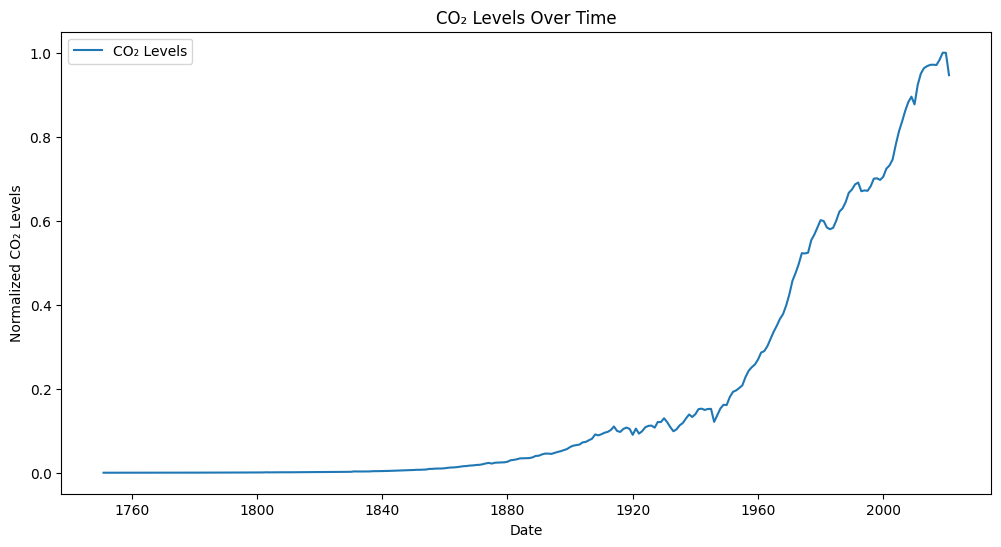

In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, LSTM, Flatten, Dropout

file_path = 'global_dataset.csv'
data = pd.read_csv(file_path)


data = data.drop(columns=['Unnamed: 0'])
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)

scaler = MinMaxScaler()
data['co2'] = scaler.fit_transform(data[['co2']])

plt.figure(figsize=(12, 6))
plt.plot(data.index, data['co2'], label='CO₂ Levels')
plt.title('CO₂ Levels Over Time')
plt.xlabel('Date')
plt.ylabel('Normalized CO₂ Levels')
plt.legend()
plt.show()


In [ ]:

def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length])
    return np.array(X), np.array(y)

sequence_length = 12
co2_values = data['co2'].values

X, y = create_sequences(co2_values, sequence_length)

X = X.reshape((X.shape[0], X.shape[1], 1))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.0714 - val_loss: 0.0043 - learning_rate: 0.0010
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0044 - val_loss: 0.0037 - learning_rate: 0.0010
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0038 - val_loss: 4.7855e-04 - learning_rate: 0.0010
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0016 - val_loss: 0.0012 - learning_rate: 0.0010
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0018 - val_loss: 2.8679e-04 - learning_rate: 0.0010
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 7.2133e-04 - val_loss: 2.7215e-04 - learning_rate: 0.0010
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0011 - val_loss: 3.7972e-04 - learning_rate: 0.0010
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0013 - val_loss: 2.6040e-04 - learning_rate: 0.0010
Epoch 9/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 6.8270e-04 - val_loss: 3.1439e-04 - learning_rat

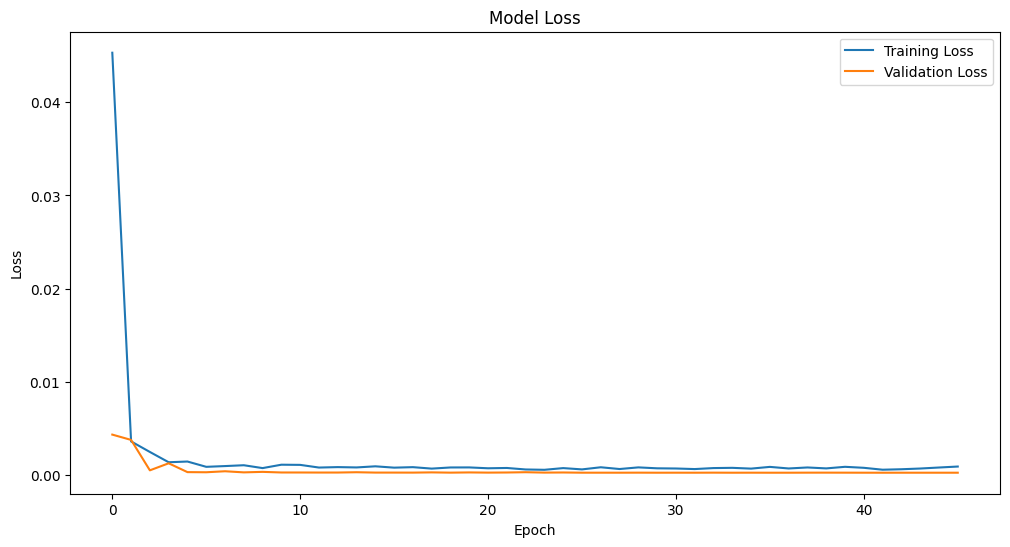

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

model = Sequential([
    Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(sequence_length, 1)),
    Dropout(0.3),
    LSTM(100, return_sequences=True),
    Dropout(0.3),
    LSTM(50, return_sequences=False),
    Dense(50, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=16,
    validation_data=(X_test, y_test),
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:

import numpy as np
import plotly.graph_objects as go
from sklearn.preprocessing import MinMaxScaler

future_years = np.arange(2021, 2031)
future_X = co2_values[-sequence_length:]
future_co2 = []

for _ in future_years:
    future_X_reshaped = future_X.reshape((1, sequence_length, 1))
    predicted = model.predict(future_X_reshaped)
    future_co2.append(predicted[0][0])
    future_X = np.append(future_X[1:], predicted[0][0])

future_co2 = scaler.inverse_transform(np.array(future_co2).reshape(-1, 1)).flatten()

historical_co2 = scaler.inverse_transform(data['co2'].values.reshape(-1, 1)).flatten()
all_years = np.concatenate((data.index.year, future_years))
all_co2 = np.concatenate((historical_co2, future_co2))

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=data.index.year,
    y=historical_co2,
    mode='lines+markers',
    name='Historical CO₂',
    hovertemplate='Year: %{x}<br>CO₂: %{y:.2f} million tonnes'
))

fig.add_trace(go.Scatter(
    x=future_years,
    y=future_co2,
    mode='lines+markers',
    name='Future Predictions',
    hovertemplate='Year: %{x}<br>CO₂: %{y:.2f} million tonnes'
))

fig.update_layout(
    title='CO₂ Emissions Over Time (Historical and Predicted)',
    xaxis=dict(
        title='Year',
        tickmode='array',
        tickvals=list(range(1750, 2001, 50)) + [2050, 2100],
        title_font=dict(size=14),
    ),
    yaxis=dict(
        title='CO₂ Emissions (Million Tonnes)',
        title_font=dict(size=14),
    ),
    hovermode='closest'
)

fig.show()



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


y_pred = model.predict(X_test)

y_test = y_test.reshape(-1, 1)
y_pred = y_pred.reshape(-1, 1)

mae = mean_absolute_error(y_test, y_pred)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))

r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.2f}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Mean Absolute Error (MAE): 0.01
Root Mean Squared Error (RMSE): 0.01
R² Score: 1.00
